In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from model import MNISTVAE
from tqdm import tqdm
from loss import VAELoss

/home/ubuntu/.cache/pypoetry/virtualenvs/implicit-fields-X0752H85-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.manual_seed(42)

In [5]:
BATCH_SIZE = 128
LR = 3e-4
WEIGHT_DECAY = 0.0
LATENT_DIM = 2
EPOCHS = 10
B_NORM = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
train_dataset = MNIST(root="./data", train=True, download=False, transform=ToTensor())
test_dataset = MNIST(root="./data", train=False, download=False, transform=ToTensor())

train_dataset, val_dataset = random_split(train_dataset, lengths=[0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [8]:
model = MNISTVAE(latent_dim=LATENT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [82]:
def run_eval(model, loader, desc="", device="cpu"):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, _ in tqdm(loader, desc=desc):
            X = X.to(device)
            output = model(X)
            pred = output["output"]
            mu = output["mu"]
            logvar = output["logvar"]

            kld_weight = B_NORM * LATENT_DIM / (28**2)
            criterion = VAELoss(kld_weight=kld_weight)
            loss = criterion(X, pred, mu, logvar)
            
            total_loss += loss.item()

    loss = total_loss / len(val_loader)
    return loss

def train(model, optimizer, train_loader, val_loader, test_loader, epochs, device, save="./weights.pt"):
    model = model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, _ in tqdm(train_loader, desc=f"[Epoch {epoch}]"):
            X = X.to(device)
            output = model(X)
            pred = output["output"]
            mu = output["mu"]
            logvar = output["logvar"]

            kld_weight =  B_NORM * LATENT_DIM / (28**2) 
            criterion = VAELoss(kld_weight=kld_weight)
            loss = criterion(X, pred, mu, logvar)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_losses.append(loss.item())

        train_loss /= len(train_loader)

        # calculate validation loss
        val_loss = run_eval(model, val_loader, desc="[Val]", device=device)
        val_losses.append(val_loss)

        print(f"==Epoch {epoch}==")
        print(f"Train Loss: {train_loss}")
        print(f"Val Loss: {val_loss}")
        

    # calculate loss on test set
    test_loss = run_eval(model, test_loader, desc="[Test]", device=device)

    print("=============")
    print(f"Test Loss: {test_loss}")

    # save weights
    torch.save(model.state_dict(), save)

    return {"model": model, "train_losses": train_losses, "val_losses": val_losses, "test_loss": test_loss}

In [83]:
result = train(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    epochs=EPOCHS,
)

result

[Epoch 0]:   2%|▏         | 9/375 [00:00<00:04, 82.21it/s]

[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.55it/s]


==Epoch 0==
Train Loss: 0.10131788088877995
Val Loss: 0.06917989571043785


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.30it/s]


==Epoch 1==
Train Loss: 0.06124992249409358
Val Loss: 0.05568107419667092


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.21it/s]


==Epoch 2==
Train Loss: 0.053613207548856734
Val Loss: 0.05189505659360835


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.72it/s]


==Epoch 3==
Train Loss: 0.05101142053802808
Val Loss: 0.050201617419085603


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.31it/s]


==Epoch 4==
Train Loss: 0.04964196285605431
Val Loss: 0.049130061205397264


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.76it/s]


==Epoch 5==
Train Loss: 0.048715156545241674
Val Loss: 0.04836819237692559


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.31it/s]


==Epoch 6==
Train Loss: 0.04802551422516505
Val Loss: 0.04777950908433884


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.64it/s]


==Epoch 7==
Train Loss: 0.04753225378195445
Val Loss: 0.047590277573846755


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.51it/s]


==Epoch 8==
Train Loss: 0.04709481430053711
Val Loss: 0.047269607676153486


[Val]: 100%|██████████| 94/94 [00:00<00:00, 106.98it/s]


==Epoch 9==
Train Loss: 0.0468254237473011
Val Loss: 0.04681691784966499


[Test]: 100%|██████████| 79/79 [00:00<00:00, 108.15it/s]

Test Loss: 0.0390138280914819


{'model': MNISTVAE(
   (encoder): Encoder(
     (conv1): Sequential(
       (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (conv2): Sequential(
       (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (conv3): Sequential(
       (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (fc_mu): Linear(in_features=1024, out_features=2, bias=True)
     (fc_logvar): Linear(in_features=1024, out_features=2, bias=True)
   )
   (decoder): Decoder(
     (ztransform): Linear(in_features=2, out_features=1024, bias=True)
     (tconv1): Sequential(
       (0): ConvTranspose2d(64

### Loss Curve

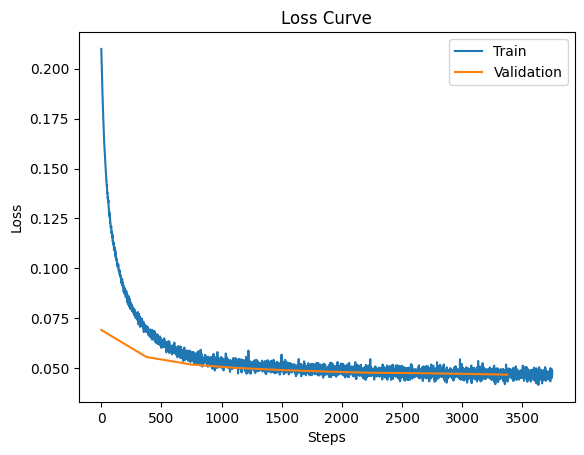

In [84]:
train_losses, val_losses = result["train_losses"], result["val_losses"]

plt.title("Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")

steps_per_epoch = len(train_losses) // len(val_losses)

plt.plot(range(len(train_losses)), train_losses, label="Train")
plt.plot(range(0, len(train_losses), steps_per_epoch), val_losses, label="Validation")
plt.legend()

### Embeddings

In [9]:
vae = MNISTVAE(latent_dim=LATENT_DIM).to(DEVICE)
vae.load_state_dict(torch.load("./weights.pt"))

<All keys matched successfully>

In [10]:
latents = []
classes = []

model.eval()

with torch.no_grad():
    for X, Y in tqdm(test_loader):
        X = X.to(DEVICE)
        output = vae(X)
        z = output["latent"]

        latents.append(z)
        classes.append(Y)

latents = torch.concat(latents, dim=0).cpu().numpy()
classes = torch.concat(classes, dim=0).cpu().numpy()

latents.size, classes.size

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:00<00:00, 79.41it/s] 


(20000, 10000)

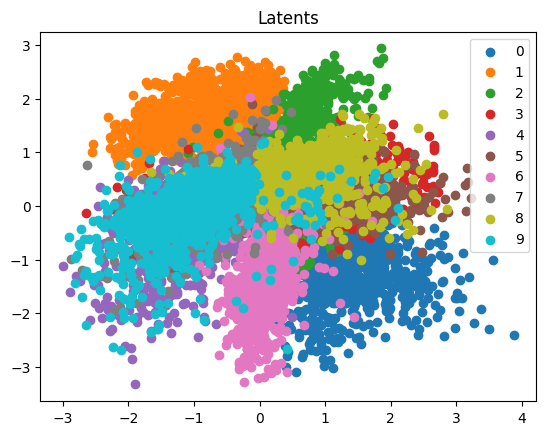

In [11]:
import matplotlib as mpl
import numpy as np

plt.title("Latents")

cmap = mpl.colormaps['tab10']
colors = [cmap(i/10) for i in range(10)]
colors = np.array(colors)

for i in range(10):
    cls_latents = latents[classes == i]
    plt.scatter(cls_latents[:, 0], cls_latents[:, 1], color=cmap(i/10), label=i)

plt.legend()

### Reconstruction

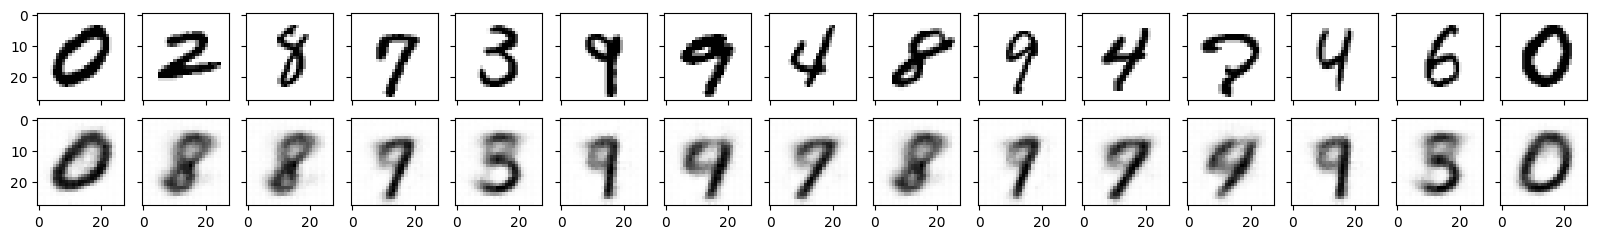

In [31]:
import numpy as np
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

indices = np.random.choice(range(len(test_dataset)), size=n_images, replace=False)
X = torch.cat([test_dataset[i][0] for i in indices]).unsqueeze(1).to("cuda")

with torch.no_grad():
    X_hat = vae(X)["output"]

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

images = torch.cat((X, X_hat))

for i, ax in enumerate(axes.flatten()):
    img = images[i].squeeze(0).cpu().numpy()
    ax.imshow(img, cmap="binary")

### Sampling From VAE

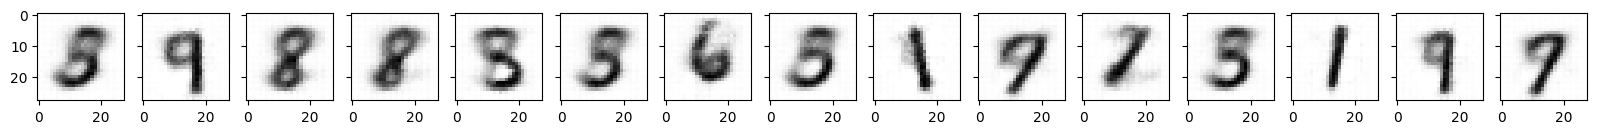

In [35]:
num_samples = 15

with torch.no_grad():
    samples = vae.sample(num_samples=num_samples, device=DEVICE)

fig, axes = plt.subplots(nrows=1, ncols=num_samples, 
                         sharex=True, sharey=True, figsize=(20, 2.5))

for i, ax in enumerate(axes):
    img = samples[i].squeeze(0).cpu().numpy()
    ax.imshow(img, cmap="binary")